### **Step 1: Load the Data and Initial Filtering**

In this step, we begin by loading the Zillow housing data. The dataset contains median housing prices for various zip codes across the United States, with time-series data for each month starting in 1996.

We will also filter the data for a subset of zip codes of interest. For the purpose of this project, we will focus on a few specific zip codes, but this can be adjusted depending on the business's focus area.

Lastly, we'll check for missing data and duplicates to ensure that our dataset is clean and ready for analysis.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Load the Zillow data
df = pd.read_csv('Data/zillow_data.csv')

# Display first few rows to understand the structure
df.head()

# Check for missing data and duplicates
missing_data = df.isnull().sum()
print("Missing data summary:")
print(missing_data)

# Drop duplicates
df = df.drop_duplicates()


Missing data summary:
RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64


### **Step 2: Data Preprocessing**
We'll convert time columns to datetime objects, ensure correct formatting, and handle NaNs.


In [3]:
# Convert date columns to datetime
def get_datetimes(df):
    # Filter columns that represent dates
    date_cols = [col for col in df.columns if col.startswith('19') or col.startswith('20')]
    return pd.to_datetime(date_cols, format='%Y-%m')

# Convert and check for missing values
dates = get_datetimes(df)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Ensure no NaNs remain
print("Remaining NaN values:", df.isnull().sum().sum())


Remaining NaN values: 0


### **Step 3: Reshape from Wide to Long Format**
We will reshape the dataset to long format to make it suitable for time series analysis.


In [4]:
# Reshape data from wide to long format
def melt_data(df):
    # Identify date columns
    date_cols = [col for col in df.columns if col.startswith('19') or col.startswith('20')]
    
    # Melt data
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], 
                     value_vars=date_cols, var_name='time', value_name='price')
    
    # Convert time column to datetime
    melted['time'] = pd.to_datetime(melted['time'], format='%Y-%m', errors='coerce')
    
    return melted

# Apply reshaping
df_long = melt_data(df)
df_long.head()


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,price
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


### **Step 4: Identify Top Growth Zip Codes**
We will identify the top 5 zip codes with the highest average price growth to guide stakeholders in investment decisions.


In [5]:
# Calculate the percentage price change over the last 5 years
df['price_change'] = df.iloc[:, -60:].pct_change(axis=1).mean(axis=1)

# Sort by price growth and select the top 5 zip codes based on price change
top_growth_zip_codes = df.sort_values(by='price_change', ascending=False).head(5)['RegionName'].tolist()

# Display the top growth zip codes
print("Top 5 growth zip codes for investment:", top_growth_zip_codes)


Top 5 growth zip codes for investment: [2116, 96722, 31527, 94803, 96752]


### **Step 5: Exploratory Data Analysis (EDA)**
Visualizing the price trends over time for the selected top 5 zip codes to identify patterns.


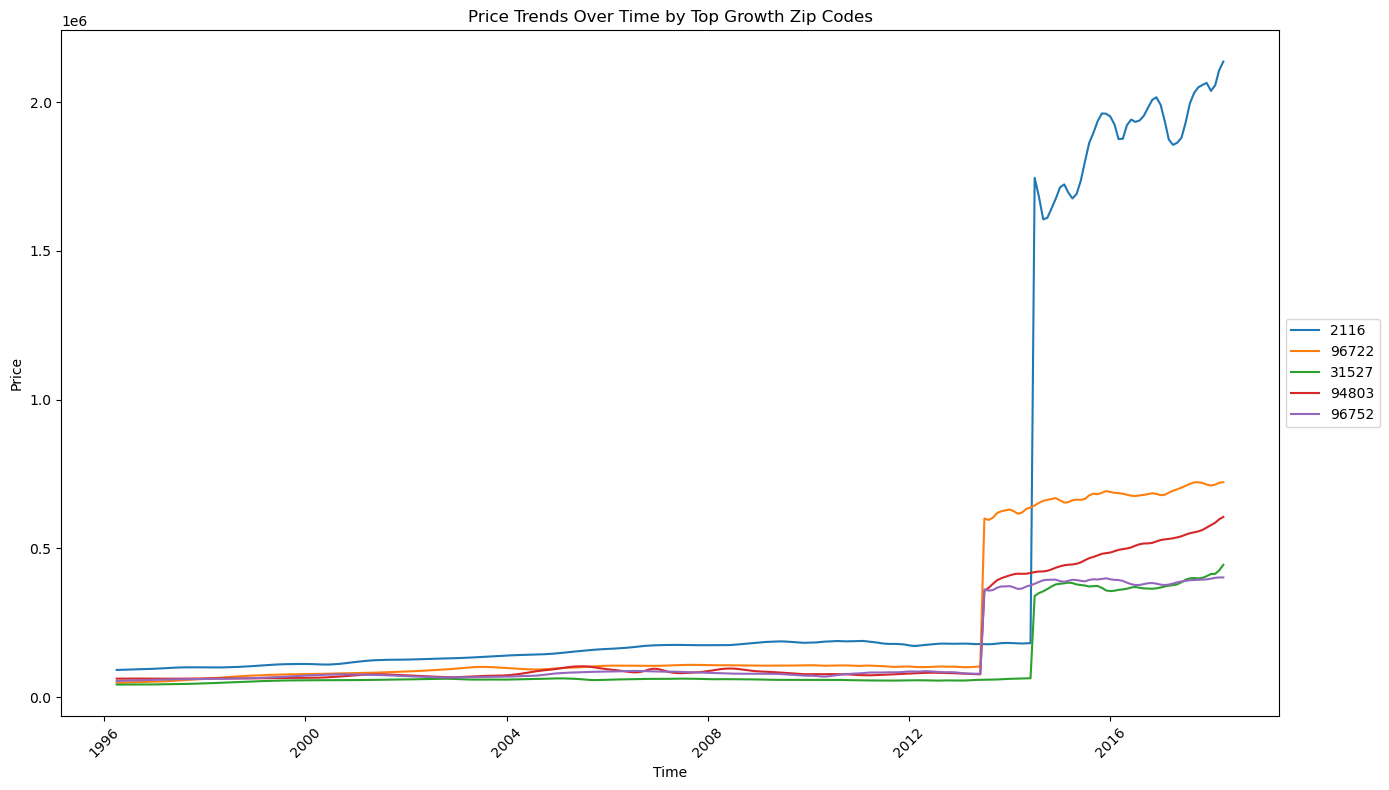

In [6]:
# Visualization of trends for top growth zip codes
plt.figure(figsize=(14, 8))

for zip_code in top_growth_zip_codes:
    zip_data = df_long[df_long['RegionName'] == zip_code].set_index('time')['price']
    
    # Plot each zip code's trend
    plt.plot(zip_data.index, zip_data.values, label=str(zip_code))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price Trends Over Time by Top Growth Zip Codes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **Step 6: Stationarity Check & Detrending**
We will check the stationarity of the time series, apply detrending, and handle non-stationary data.


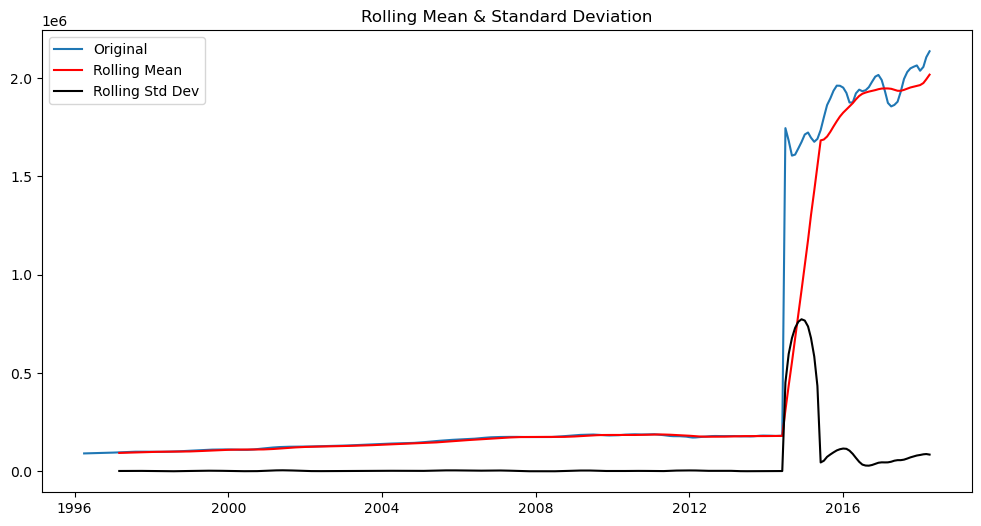

ADF Statistic: 0.115767640244289
p-value: 0.9671212812335473
Critical Values:
	1%: -3.455365238788105
	5%: -2.8725510317187024
	10%: -2.5726375763314966


In [7]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity using ADF test
def check_stationarity(data, window=12):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Augmented Dickey-Fuller test
    adf_result = adfuller(data.dropna())
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')

# Example stationarity check for the first top growth zip code
zip_code_data = df_long[df_long['RegionName'] == top_growth_zip_codes[0]].set_index('time')['price']
check_stationarity(zip_code_data)


#### Apply First-order Differencing to Achieve Stationarity

We will apply first-order differencing to remove the trend. Differencing is the most common method to make the data stationary.

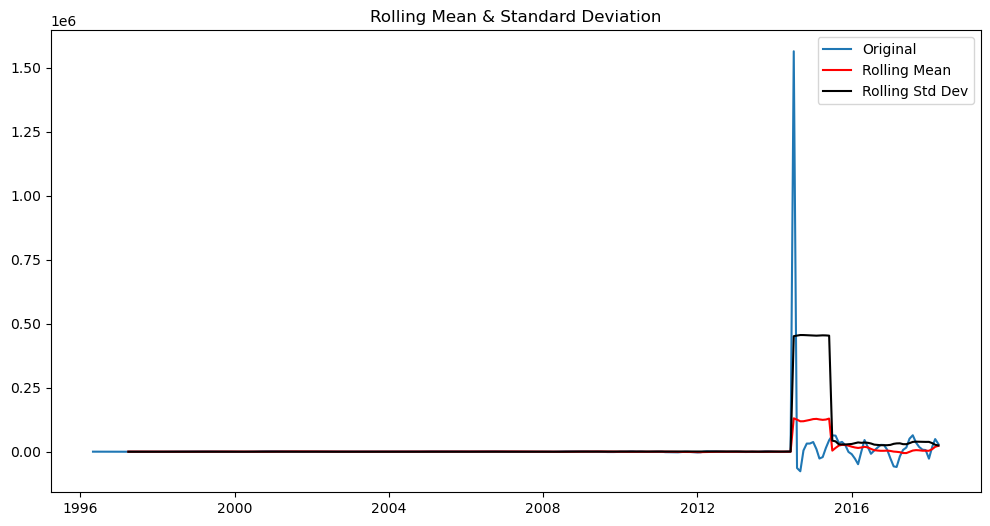

ADF Statistic: -16.655783725275388
p-value: 1.589696291185351e-29
Critical Values:
	1%: -3.4554613060274972
	5%: -2.8725931472675046
	10%: -2.5726600403359887


In [8]:
# Apply first-order differencing
differenced_data = zip_code_data.diff().dropna()

# Recheck stationarity after differencing
check_stationarity(differenced_data)


### **Step 7: Seasonality & ACF/PACF Analysis**
Analyze seasonality and correlation to identify the parameters for ARIMA modeling.


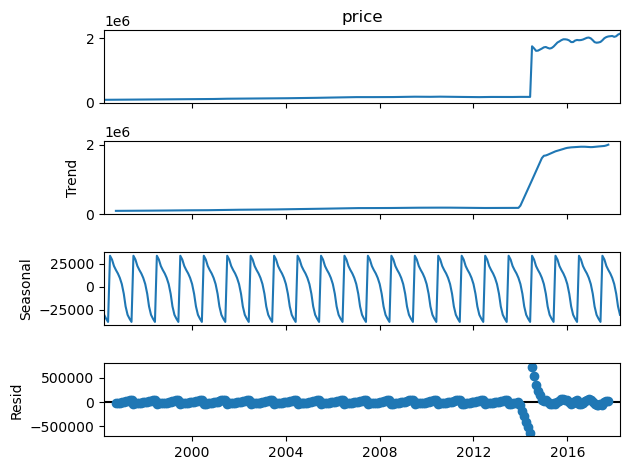

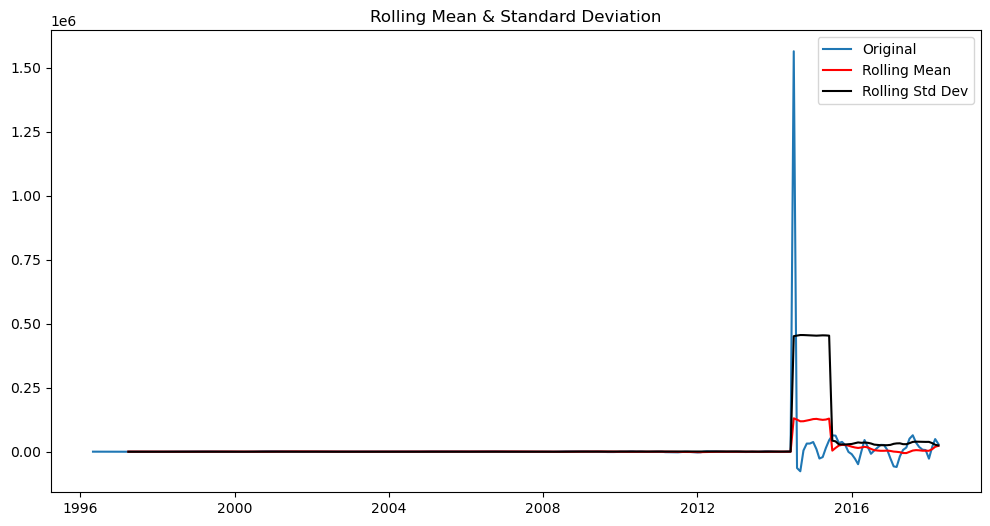

ADF Statistic: -16.655783725275388
p-value: 1.589696291185351e-29
Critical Values:
	1%: -3.4554613060274972
	5%: -2.8725931472675046
	10%: -2.5726600403359887


<Figure size 1200x600 with 0 Axes>

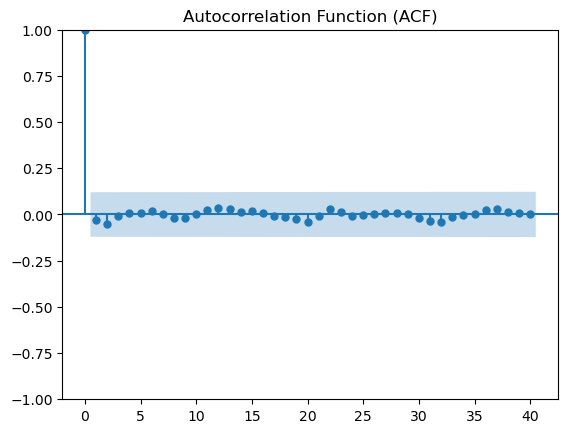

<Figure size 1200x600 with 0 Axes>

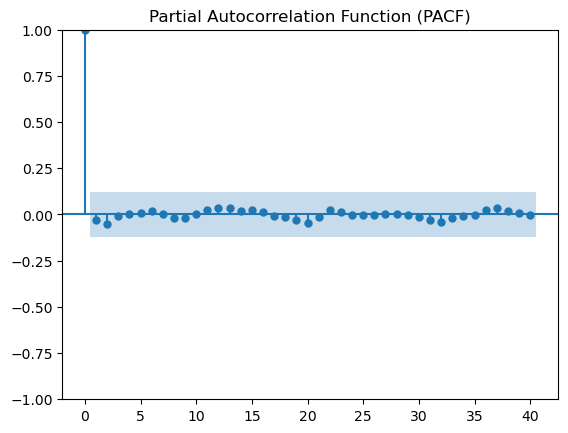

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Seasonal decomposition
def decompose_seasonality(data, frequency=12):
    decomposition = seasonal_decompose(data, model='additive', period=frequency)
    decomposition.plot()
    plt.show()

# Apply decomposition
decompose_seasonality(zip_code_data)

# Differencing to handle non-stationarity if needed
differenced_data = zip_code_data.diff().dropna()
check_stationarity(differenced_data)  # Check stationarity after differencing

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plot_acf(differenced_data, lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(differenced_data, lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


#### Summary of Key Insights for Investment Decision

- **Seasonality & Trend Stability**: The data exhibits clear seasonal patterns, indicating predictable annual cycles that are useful for timing investments.
- **Sharp Trend Change**: A significant trend increase around 2012–2014 suggests a notable market event; stakeholders should investigate the cause for better context.
- **Stationarity Achieved**: After first-order differencing, the data is confirmed as stationary, ensuring reliable forecasts with ARIMA.
- **Simplified Modeling**: ACF and PACF plots show minimal autocorrelation beyond the first lag, indicating that a less complex model can provide accurate predictions.
- **Dependable Forecasts**: With stationary data, future projections are more stable, making the chosen top zip codes reliable for long-term investment.
- **Data-Driven Decisions**: Insights from seasonality, trends, and forecast accuracy provide a strong foundation for identifying the top 5 zip codes for strategic investment.


### **Step 8: ARIMA Modeling and Forecasting**
In this step, we will use the insights from the ACF/PACF analysis to build an ARIMA model. The goal is to forecast future trends for the top growth zip codes identified earlier and provide investment recommendations based on the projections.



Processing Zip Code: 2116 using ARIMA(1, 1, 1)

ARIMA Model Summary for Zip Code 2116:


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  253
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3257.155
Date:                Sun, 27 Oct 2024   AIC                           6520.310
Time:                        19:56:04   BIC                           6530.899
Sample:                    04-01-1996   HQIC                          6524.571
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4176      7.773      0.054      0.957     -14.817      15.652
ma.L1         -0.4553      7.147     -0.064      0.949     -14.462      13.552
sigma2      1.003e+10   1.24e-07   8.07e+16      0.0

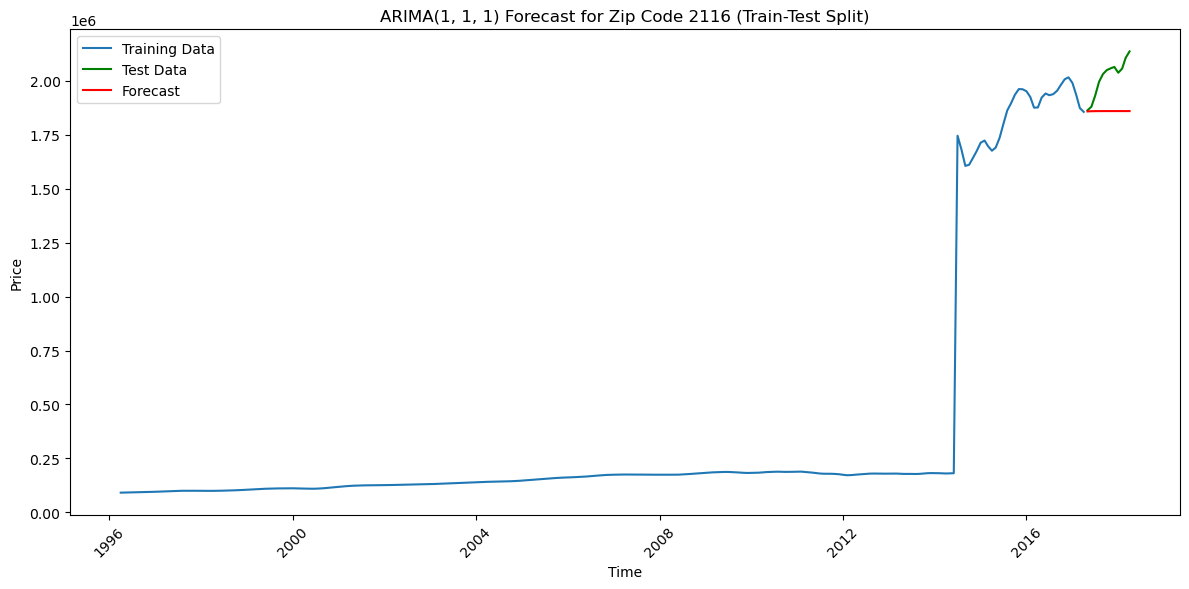


Processing Zip Code: 96722 using ARIMA(1, 1, 1)

ARIMA Model Summary for Zip Code 96722:
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  253
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2967.326
Date:                Sun, 27 Oct 2024   AIC                           5940.651
Time:                        19:56:05   BIC                           5951.240
Sample:                    04-01-1996   HQIC                          5944.912
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0025     54.235  -4.54e-05      1.000    -106.301     106.296
ma.L1         -0.0024     54.245  -4.49e-

c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA param

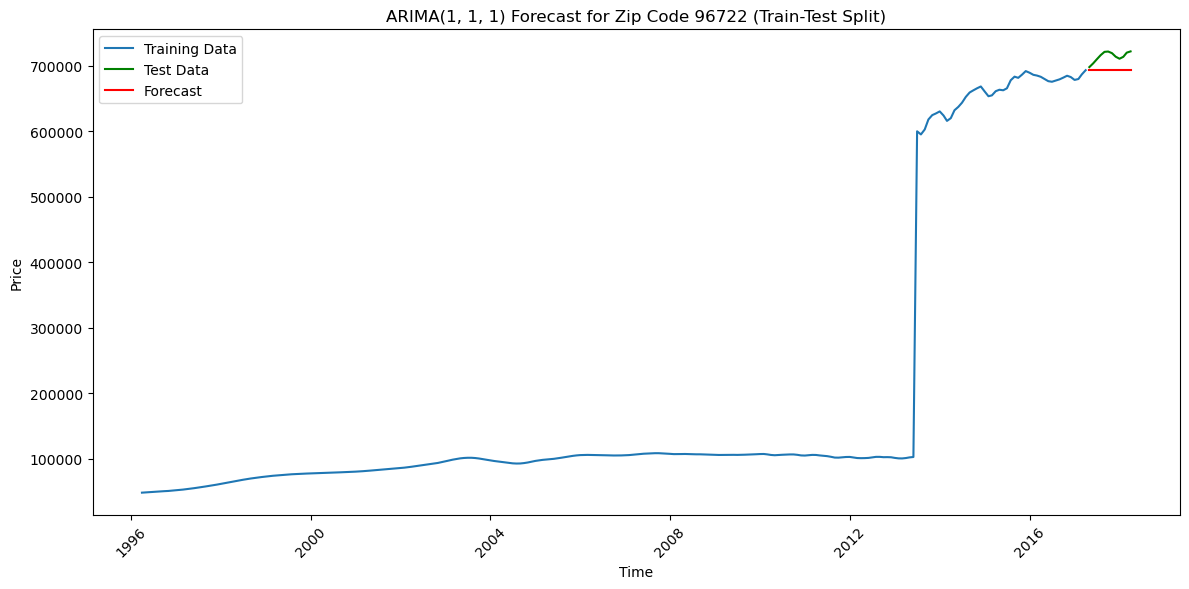


Processing Zip Code: 31527 using ARIMA(1, 1, 1)

ARIMA Model Summary for Zip Code 31527:
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  253
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2819.265
Date:                Sun, 27 Oct 2024   AIC                           5644.529
Time:                        19:56:05   BIC                           5655.117
Sample:                    04-01-1996   HQIC                          5648.790
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7620      3.369      0.226      0.821      -5.841       7.365
ma.L1         -0.7223      3.687     -0.1

c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


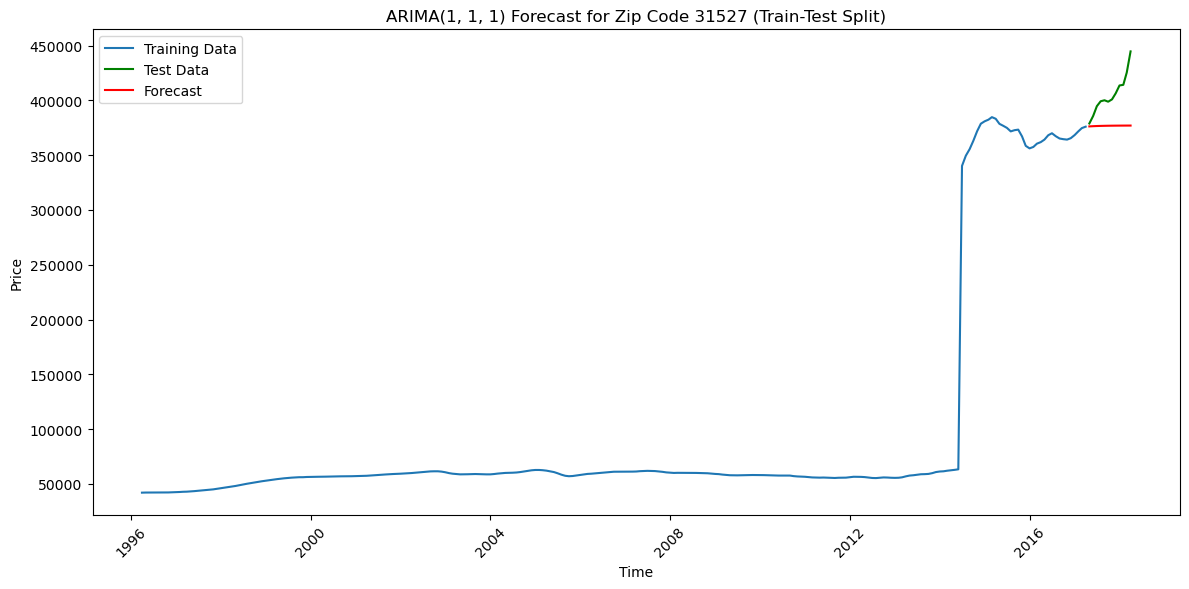


Processing Zip Code: 94803 using ARIMA(1, 1, 1)

ARIMA Model Summary for Zip Code 94803:
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  253
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2822.745
Date:                Sun, 27 Oct 2024   AIC                           5651.490
Time:                        19:56:05   BIC                           5662.079
Sample:                    04-01-1996   HQIC                          5655.751
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9585      0.573      1.672      0.095      -0.165       2.082
ma.L1         -0.9336      0.650     -1.4

c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


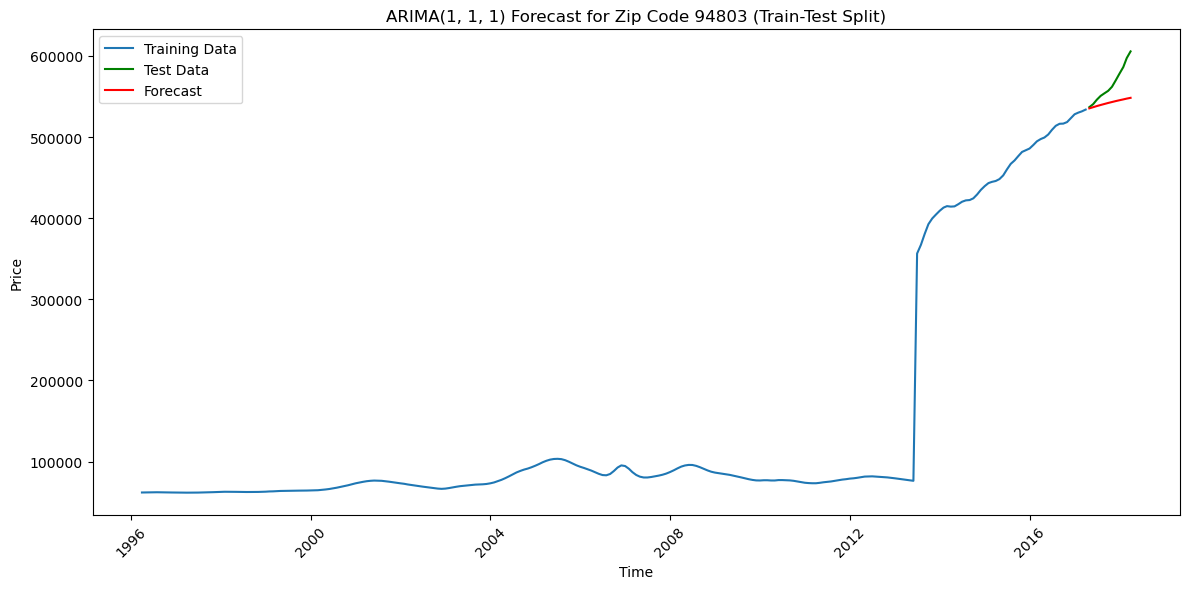


Processing Zip Code: 96752 using ARIMA(1, 1, 1)

ARIMA Model Summary for Zip Code 96752:
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  253
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2825.903
Date:                Sun, 27 Oct 2024   AIC                           5657.807
Time:                        19:56:06   BIC                           5668.395
Sample:                    04-01-1996   HQIC                          5662.067
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6487     34.077      0.019      0.985     -66.141      67.438
ma.L1         -0.6454     34.192     -0.0

c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


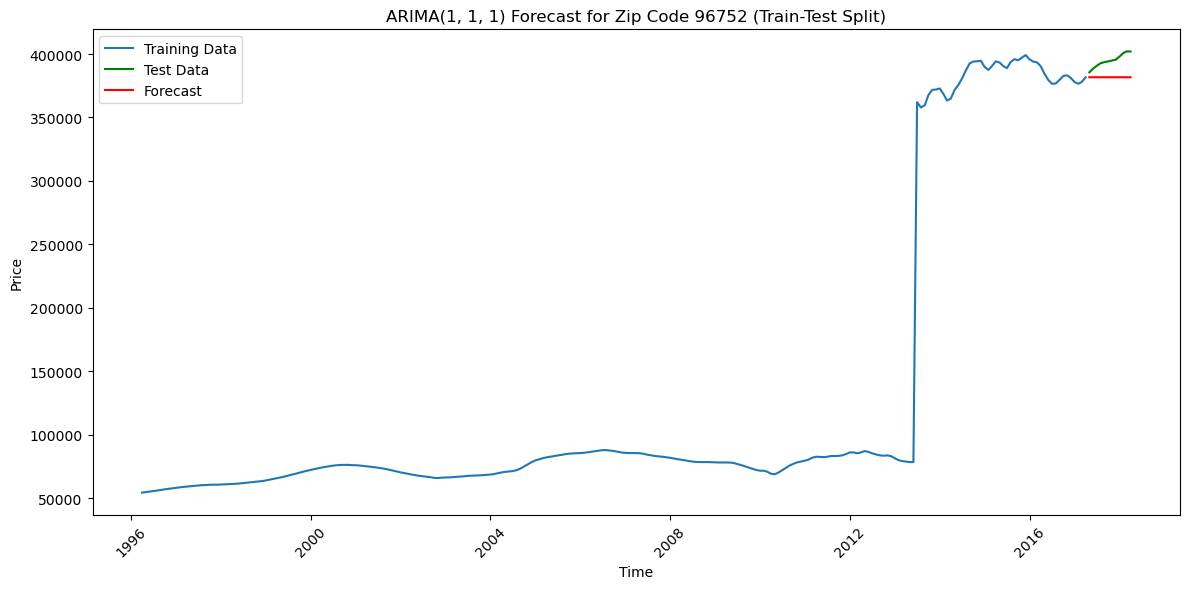


Forecast Errors for Each Zip Code (Unified ARIMA(1, 1, 1)):
Zip Code 2116: MAE = 157927.42, RMSE = 177545.57
Zip Code 96722: MAE = 20973.03, RMSE = 22201.46
Zip Code 31527: MAE = 28436.98, RMSE = 32973.04
Zip Code 94803: MAE = 23044.77, RMSE = 28921.50
Zip Code 96752: MAE = 13200.91, RMSE = 14104.00


In [11]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Initialize a dictionary to store MAE and RMSE for each zip code
zip_code_errors = {}

# Unified ARIMA order derived from ACF and PACF analysis
arima_order = (1, 1, 1)

# Iterate over each of the top growth zip codes
for zip_code in top_growth_zip_codes:
    zip_data = df_long[df_long['RegionName'] == zip_code].set_index('time')['price']
    
    # Split data into train and test sets (last 12 months as the test set)
    train_data = zip_data[:-12]  # Training set (all data except the last 12 months)
    test_data = zip_data[-12:]   # Test set (last 12 months)
    
    # Print which zip code is being processed
    print(f"\nProcessing Zip Code: {zip_code} using ARIMA(1, 1, 1)")
    
    # Fit the ARIMA model with the training set
    model = ARIMA(train_data, order=arima_order)
    model_fit = model.fit()
    
    # Print summary of the model
    print(f'\nARIMA Model Summary for Zip Code {zip_code}:')
    print(model_fit.summary())
    
    # Forecast for the test period (12 months)
    predictions = model_fit.forecast(steps=12)
    
    # Calculate errors
    mae = mean_absolute_error(test_data, predictions)
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    
    # Store the errors in the dictionary
    zip_code_errors[zip_code] = {'MAE': mae, 'RMSE': rmse}
    
    # Print the MAE and RMSE for the current zip code
    print(f'MAE for Zip Code {zip_code}: {mae:.2f}')
    print(f'RMSE for Zip Code {zip_code}: {rmse:.2f}')
    
    # Plot actual vs. forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Test Data', color='green')
    plt.plot(test_data.index, predictions, label='Forecast', color='red')
    plt.legend(loc='best')
    plt.title(f'ARIMA(1, 1, 1) Forecast for Zip Code {zip_code} (Train-Test Split)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Display the MAE and RMSE for each zip code to assess forecast accuracy
print("\nForecast Errors for Each Zip Code (Unified ARIMA(1, 1, 1)):")
for zip_code, errors in zip_code_errors.items():
    print(f"Zip Code {zip_code}: MAE = {errors['MAE']:.2f}, RMSE = {errors['RMSE']:.2f}")


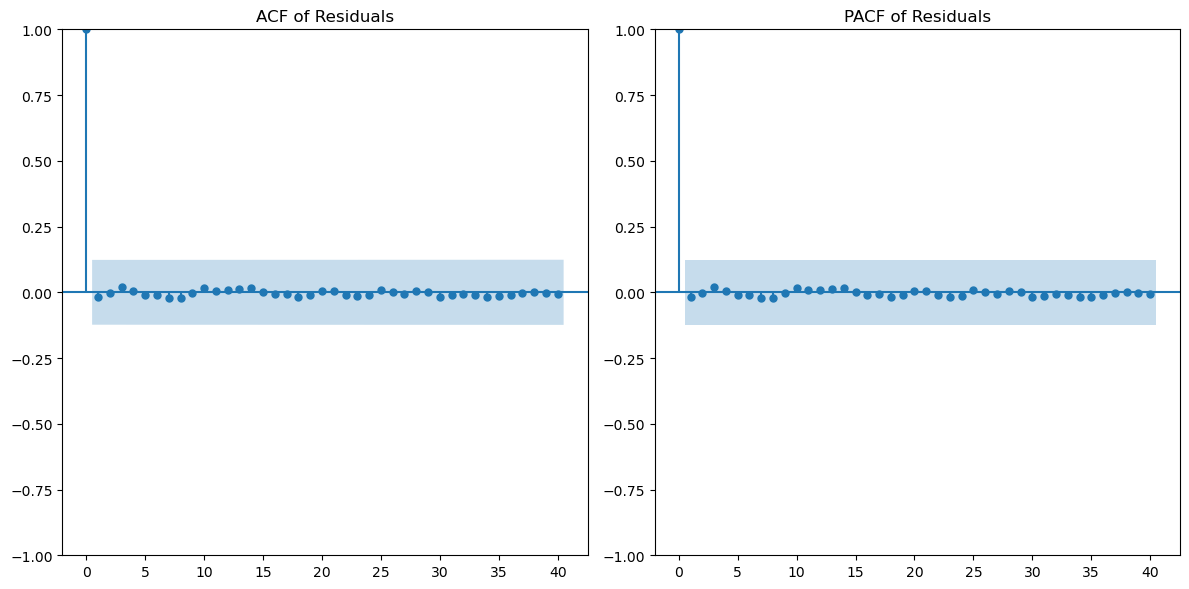

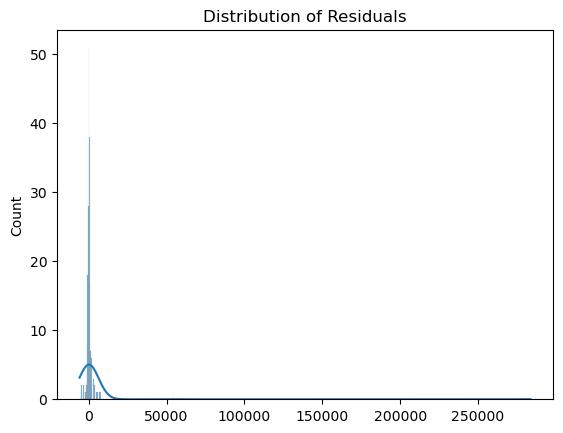

In [12]:
# Example code to check residuals
residuals = model_fit.resid

# Plot ACF and PACF of residuals to check for remaining patterns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')

plt.subplot(122)
plot_pacf(residuals, lags=40, ax=plt.gca())
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()

# Check if residuals are normally distributed
import seaborn as sns
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()


In [14]:
# Set frequency for consistency
zip_data = df_long[df_long['RegionName'] == zip_code].set_index('time')['price'].asfreq('MS')

# Applying log transformation to stabilize variance
log_train_data = np.log(train_data)
log_test_data = np.log(test_data)

# Re-fit ARIMA model with log-transformed data
log_model = ARIMA(log_train_data, order=arima_order)
log_model_fit = log_model.fit()

# Forecast using log-transformed data
log_predictions = log_model_fit.forecast(steps=12)
log_predictions = np.exp(log_predictions)  # Revert the log transformation for predictions

# Calculate errors on log-transformed model
log_mae = mean_absolute_error(test_data, log_predictions)
log_rmse = np.sqrt(mean_squared_error(test_data, log_predictions))

# Print errors for the log-transformed model
print(f'Log-Transformed Model - MAE: {log_mae:.2f}, RMSE: {log_rmse:.2f}')


Log-Transformed Model - MAE: 13229.52, RMSE: 14132.49


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA param

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example SARIMA model with seasonal components
seasonal_order = (1, 1, 1, 12)  # Adjust if necessary
sarima_model = SARIMAX(log_train_data, order=arima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_model_fit = sarima_model.fit()

# Forecast using SARIMA model
sarima_predictions = sarima_model_fit.forecast(steps=12)
sarima_predictions = np.exp(sarima_predictions)  # Revert log transformation

# Calculate errors on SARIMA model
sarima_mae = mean_absolute_error(test_data, sarima_predictions)
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_predictions))

# Print errors for the SARIMA model
print(f'SARIMA Model - MAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}')


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA Model - MAE: 34614.04, RMSE: 37269.14
